# **U-Net Model Training Notebook**

## **Overview:**
- Implements a **U-Net model** for **skin lesion segmentation** on the **ISIC 2018 dataset**.
- Uses **pretrained ResNet-34** as the encoder for feature extraction.
- The **decoder is trained from scratch** on the ISIC 2018 dataset for lesion segmentation.
- Optimized with **Dice + BCE loss** for better medical segmentation performance.
- Tracks **training & validation loss, Dice Score, and IoU** over multiple epochs.
- Saves the **best model** based on the lowest validation loss.
- Provides **visualization of predictions** on test images for qualitative evaluation.

## **Metrics Used:**

- **Dice Score** (overlap between prediction and ground truth).
- **IoU (Intersection over Union)** for evaluating segmentation quality.
- **Training & Validation Loss** (to assess convergence and generalization).

# Step 1: Importing Libraries and Mounting Files from Google Drive

In [ ]:
!pip install torch torchvision torchaudio torchmetrics
!pip install timm==0.9.2
!pip install segmentation-models-pytorch

In [ ]:
import torch
import timm
import segmentation_models_pytorch as smp

print("Torch version:", torch.__version__)
print("Timm version:", timm.__version__)
print("Segmentation Models PyTorch imported successfully!")

Torch version: 2.5.1+cu124
Timm version: 0.9.2
Segmentation Models PyTorch imported successfully!


In [ ]:
import os
import numpy as np
import torchmetrics
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from google.colab import drive


In [ ]:
# Try to detect if running in Colab
IN_COLAB = "google.colab" in str(get_ipython())

# Define dataset path
if IN_COLAB:
    print("Running in Google Colab: Mounting Drive...")
    drive.mount('/content/drive')
    BASE_DIR = BASE_DIR = "/content/drive/MyDrive/swinunet-medical-segmentation/dataset/processed_dataset"
else:
    print("Running on a local machine: Set BASE_DIR manually!")
    BASE_DIR = "/path/to/local/dataset/processed_dataset"  # Change this when running locally

# Print the dataset directory
print(f"Dataset directory: {BASE_DIR}")

Running in Google Colab: Mounting Drive...
Mounted at /content/drive
Dataset directory: /content/drive/MyDrive/swinunet-medical-segmentation/dataset/processed_dataset


# Step 2: Verify GPU and Environment

In [ ]:
print("GPU Available:", torch.cuda.is_available()) # checks if a GPU is accessible.

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Running on device:", device)

GPU Available: True
GPU Name: Tesla T4
Running on device: cuda


# Step 3: Define a PyTorch Dataset for Our Preprocessed .npy Files

Now we’ll create a custom Dataset class that reads our images and masks from the .npy files. This allows us to easily use DataLoader for batching and shuffling. (This is a common practice for PyTorch).

In [ ]:
class ISICDataset(Dataset):
    def __init__(self, images_path, masks_path, transform=None): # We load two .npy files (images & masks). Optionally store a transform if we want to apply augmentations later
        """
        images_path: Path to the .npy file containing image data (shape: (N, H, W, C))
        masks_path : Path to the .npy file containing mask data  (shape: (N, H, W))
        transform  : (Optional) Albumentations transform for on-the-fly augmentations
        """
        # 1. Load images and masks from disk
        self.images = np.load(images_path)  # shape: (N, H, W, C)
        self.masks  = np.load(masks_path)   # shape: (N, H, W)

        # 2. Store the transform if you want data augmentation later
        self.transform = transform

    def __len__(self): # Returns the total number of samples (len(self.images)). PyTorch’s DataLoader uses this to iterate
        """Return the total number of samples in this dataset."""
        return len(self.images)

    def __getitem__(self, idx): # Retrieves one (image, mask) pair at index idx
        """
        Retrieve the sample (image, mask) at index 'idx'.
        Apply optional augmentation transforms.
        Convert to PyTorch tensors if no transform is provided.
        """
        # 1. Get the raw numpy image and mask
        image = self.images[idx]  # shape: (H, W, C)
        mask  = self.masks[idx]   # shape: (H, W)

        # 2. If we have an Albumentations transform, apply it
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]  # Already a torch tensor if using ToTensorV2
            mask  = augmented["mask"]
        else:
            # Convert to PyTorch tensors manually
            image = torch.from_numpy(image).permute(2, 0, 1).float()
            mask  = torch.from_numpy(mask).long()

        # 3. Return the processed image and mask
        return image, mask

Note: We store a transform if we want to do random flips, rotations, etc. If you don’t have any transforms yet, it stays None—i.e. no augmentations.

# Step 4: Create a DataLoader for Training & Validation

Now that we have our ISICDataset class defined, let’s set up the DataLoader. This allows us to:

1.	Batch our images and masks (e.g., batches of size 8).
2.	Shuffle the data for training.
3.	Potentially use multiple workers to speed up data loading.

In [ ]:
# 1. Specify the paths to your .npy files
train_images_path = f"{BASE_DIR}/train_images.npy"
train_masks_path  = f"{BASE_DIR}/train_masks.npy"
val_images_path   = f"{BASE_DIR}/val_images.npy"
val_masks_path    = f"{BASE_DIR}/val_masks.npy"
test_images_path  = f"{BASE_DIR}/test_images.npy"  # Added test images
test_masks_path   = f"{BASE_DIR}/test_masks.npy"   # Added test masks

# 2. Instantiate your dataset objects
train_dataset = ISICDataset(
    images_path=train_images_path,
    masks_path=train_masks_path,
    transform=None  # We'll add augmentation transforms later if desired
)

val_dataset = ISICDataset(
    images_path=val_images_path,
    masks_path=val_masks_path,
    transform=None
)

test_dataset = ISICDataset(  # Added test dataset
    images_path=test_images_path,
    masks_path=test_masks_path,
    transform=None
)

# 3. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=8, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=8, shuffle=False, num_workers=2)  # Added test loader

# 4. Quick test: check shapes of a single batch
train_batch = next(iter(train_loader))
images, masks = train_batch
print("Images batch shape:", images.shape)
print("Masks batch shape:", masks.shape)

# Test that test dataset is properly loaded
test_batch = next(iter(test_loader))
test_images, test_masks = test_batch
print("Test Images batch shape:", test_images.shape)
print("Test Masks batch shape:", test_masks.shape)

Images batch shape: torch.Size([8, 3, 256, 256])
Masks batch shape: torch.Size([8, 256, 256])
Test Images batch shape: torch.Size([8, 3, 256, 256])
Test Masks batch shape: torch.Size([8, 256, 256])


# Step 5: Define the Baseline U-Net Model

In this step, we define a U-Net model using the segmentation_models_pytorch (SMP) library.
U-Net is a widely used architecture for medical image segmentation because of its encoder-decoder structure that effectively captures both global context and fine-grained details.

There are several reasons why we use U-net first instead of Swin-Unet:

1.	Simpler Debugging: U-Net is easier to work with and helps verify that the dataset and training loop work correctly.
2.	Shorter Training Time: U-Net trains faster, making it a good baseline before moving on to advanced models like Swin-Unet.
3.	Modular Approach: Once the pipeline works with U-Net, we can swap it with Swin-Unet with minimal changes.

In [ ]:
# Automatically detect and set device (GPU or CPU)
# This ensures the model runs optimally without needing manual changes.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define U-Net model
model = smp.Unet(
    encoder_name="resnet34",  # Backbone encoder (ResNet34 pretrained on ImageNet)
    encoder_weights="imagenet",  # Use pretrained weights for better feature extraction
    in_channels=3,  # Input has 3 channels (RGB images)
    classes=1,  # Output has 1 channel (binary segmentation: background vs. lesion)
)

# The model is sent to the GPU (if available)
# This ensures all computations run on the correct hardware
model = model.to(device)

# Print model summary
print(model)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 339MB/s]


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

# Step 6: Test U-Net Model on a Single Batch

Before we dive into training, we want to verify that our model is working correctly by running it on a single batch of images. This helps us catch potential issues before we begin full-scale training.

Motivation:

1.	Ensures the model is compatible with the input data.
2.	Confirms that the input and output shapes are correct.
3.	Identifies potential errors early, preventing time wastage during training.

In [ ]:
# Move a batch of images to the correct device
images, masks = next(iter(train_loader))  # Get a single batch
images = images.to(device)

# Forward pass through the model
outputs = model(images)

# Print output shape
print("U-Net output shape:", outputs.shape)

U-Net output shape: torch.Size([8, 1, 256, 256])


Note:

You might be thinking why the U-Net output has only 1 channel ([8, 1, 256, 256]). For couple of reasons:

1.	U-Net is a segmentation model, meaning its goal is to output a probability map where each pixel corresponds to a segmentation class.
2.	In binary segmentation (like lesion vs. background), the output needs only one probability per pixel.
3.	This is why the model outputs a single-channel mask, where values close to 1 represent the object (lesion), and values close to 0 represent the background.
4.	Thus, the output shape is (batch_size=8, channels=1, height=256, width=256).

# Step 7: Define the Loss Function

For binary segmentation (lesion vs. background), we need a loss function that effectively measures how well the predicted masks match the ground truth. For this project, we will be using Dice Loss, which is a common choice for medical segmentation tasks.

In [ ]:
# Define Dice loss (best for medical segmentation)
dice_loss = smp.losses.DiceLoss(mode="binary")

# Define BCE loss (pixel-wise classification)
bce_loss = nn.BCEWithLogitsLoss()

# Hybrid Loss: Combine BCE and Dice (Recommended)
def combined_loss(y_pred, y_true):
    return 0.5 * bce_loss(y_pred, y_true) + 0.5 * dice_loss(y_pred, y_true)

# Quick test: Check loss computation for one batch
y_pred = model(images)  # Forward pass

# Reshape masks to have a channel dimension (add 1 at dim=1) and convert to float
# unsqueeze(1) adds the missing channel dimension to masks, making it [8, 1, 256, 256], which matches the model output
masks = masks.unsqueeze(1).float().to(device)

# Compute loss
loss = combined_loss(y_pred, masks)
print(f"Loss for this batch: {loss.item():.4f}")

Loss for this batch: 0.7800


# Step 8: Define the Optimizer

We’ll use Adam as our optimizer, which is commonly used in deep learning due to its adaptive learning rate and efficiency.

In [ ]:
# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print("Optimizer initialized successfully!")

Optimizer initialized successfully!


# Step 9: Implement Training and Validation Loops

In [ ]:
def train_one_epoch(model, train_loader, optimizer, loss_fn, device):
    """Trains the model for one epoch and returns the average training loss."""
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.unsqueeze(1).float().to(device)  # Ensure masks have correct shape

        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)  # Forward pass
        loss = loss_fn(outputs, masks)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

    return running_loss / len(train_loader)  # Return average loss


def validate_one_epoch(model, val_loader, loss_fn, device):
    """Validates the model on the validation dataset and returns the average validation loss."""
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # No gradient computation needed
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.unsqueeze(1).float().to(device)  # Ensure masks have correct shape

            outputs = model(images)  # Forward pass
            loss = loss_fn(outputs, masks)  # Compute loss
            val_loss += loss.item()

    return val_loss / len(val_loader)  # Return average validation loss

print("Training and validation functions defined successfully!")

Training and validation functions defined successfully!


Now that the training and validation functions are defined, the next step is to train the model over multiple epochs while tracking performance.

This loop will:

1.	Train the model on the training dataset.
2.	Validate the model after each epoch.
3.	Save the model if the validation loss improves.

In [ ]:
# Initialize Dice and IoU metrics with corrections:
# For binary segmentation with a single output channel, set num_classes=1 and multiclass=False.
dice_metric = torchmetrics.Dice(num_classes=1, threshold=0.5, average="micro", multiclass=False).to(device)
iou_metric = torchmetrics.JaccardIndex(task="binary").to(device)

# Lists to store loss and metric history
train_losses = []
val_losses = []
train_dice_scores = []
val_dice_scores = []
train_iou_scores = []
val_iou_scores = []

num_epochs = 10
best_val_loss = float("inf")

for epoch in range(num_epochs):
    # Train one epoch & track Dice/IoU for training
    model.train()
    train_loss = 0.0
    train_dice = 0.0
    train_iou = 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        preds = model(images)
        # Unsqueeze masks for loss computation: shape becomes [batch, 1, 256, 256]
        loss = combined_loss(preds, masks.unsqueeze(1).float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Compute Dice & IoU for training:
        preds = torch.sigmoid(preds)  # Convert logits to probabilities
        pred_binary = (preds > 0.5).int()  # Binarize predictions
        # Unsqueeze masks for metrics as well so they have shape [batch, 1, H, W]
        train_dice += dice_metric(pred_binary, masks.unsqueeze(1).int()).item()
        train_iou += iou_metric(pred_binary, masks.unsqueeze(1).int()).item()

    # Average training loss, Dice, and IoU
    train_loss /= len(train_loader)
    train_dice /= len(train_loader)
    train_iou /= len(train_loader)

    train_losses.append(train_loss)
    train_dice_scores.append(train_dice)
    train_iou_scores.append(train_iou)

    # Validate one epoch
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    val_iou = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)
            loss = combined_loss(preds, masks.unsqueeze(1).float())
            val_loss += loss.item()

            # Compute Dice & IoU for validation
            preds = torch.sigmoid(preds)
            pred_binary = (preds > 0.5).int()
            val_dice += dice_metric(pred_binary, masks.unsqueeze(1).int()).item()
            val_iou += iou_metric(pred_binary, masks.unsqueeze(1).int()).item()

    # Average validation loss, Dice, and IoU
    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    val_iou /= len(val_loader)

    val_losses.append(val_loss)
    val_dice_scores.append(val_dice)
    val_iou_scores.append(val_iou)

    print(f"Epoch [{epoch+1}/{num_epochs}]: "
          f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
          f"Train Dice={train_dice:.4f}, Val Dice={val_dice:.4f}, "
          f"Train IoU={train_iou:.4f}, Val IoU={val_iou:.4f}")

    # Save best model if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_unet.pth")
        print(">>> Best model saved!")

Epoch [1/10]: Train Loss=0.0882, Val Loss=0.1432, Train Dice=0.9295, Val Dice=0.8968, Train IoU=0.8696, Val IoU=0.8151
>>> Best model saved!
Epoch [2/10]: Train Loss=0.0824, Val Loss=0.2238, Train Dice=0.9326, Val Dice=0.8494, Train IoU=0.8750, Val IoU=0.7431
Epoch [3/10]: Train Loss=0.0802, Val Loss=0.1674, Train Dice=0.9337, Val Dice=0.8827, Train IoU=0.8767, Val IoU=0.7917
Epoch [4/10]: Train Loss=0.0674, Val Loss=0.1314, Train Dice=0.9439, Val Dice=0.9051, Train IoU=0.8943, Val IoU=0.8275
>>> Best model saved!
Epoch [5/10]: Train Loss=0.0633, Val Loss=0.1848, Train Dice=0.9467, Val Dice=0.8706, Train IoU=0.8994, Val IoU=0.7735
Epoch [6/10]: Train Loss=0.0590, Val Loss=0.1487, Train Dice=0.9497, Val Dice=0.8983, Train IoU=0.9048, Val IoU=0.8168
Epoch [7/10]: Train Loss=0.0548, Val Loss=0.1389, Train Dice=0.9528, Val Dice=0.9042, Train IoU=0.9102, Val IoU=0.8263
Epoch [8/10]: Train Loss=0.0507, Val Loss=0.1302, Train Dice=0.9564, Val Dice=0.9123, Train IoU=0.9168, Val IoU=0.8394
>>> 

# Step 10: Load the Best Model

During training, we saved the best model (with the lowest validation loss) as "best_unet.pth". Now, we need to load that model so we can evaluate it on unseen data.

In [ ]:
# Load the best saved model
best_model = smp.Unet(
    encoder_name="resnet34",  # Ensure the same architecture as training
    encoder_weights="imagenet",
    in_channels=3,  # Our input images have 3 color channels (RGB)
    classes=1,  # Binary segmentation (lesion vs. background)
)

# Load the saved weights
best_model.load_state_dict(torch.load("best_unet.pth"))

# Move model to GPU/CPU
best_model.to(device)

# Set model to evaluation mode (important for inference)
best_model.eval()

print("Best trained U-Net model loaded successfully!")

Explanation of the preceding step:


1.	We recreate the U-Net model using the same architecture used in training.
2.	We load the saved model weights (.pth file), which contains the trained parameters.
3.	We move the model to the appropriate device (CPU/GPU).
4.	We set model.eval() because this turns off dropout and batch normalization updates, ensuring consistent predictions during inference.

# Step 11: Plotting losses, Dice Scores, and IoU Scores Over Epochs

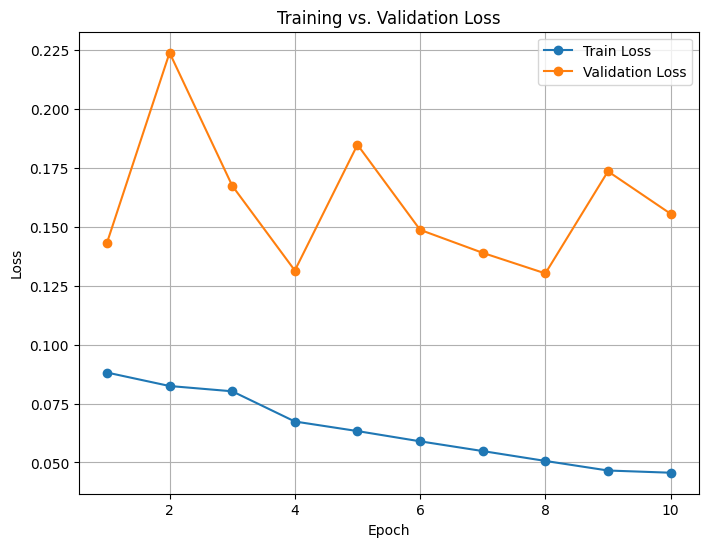

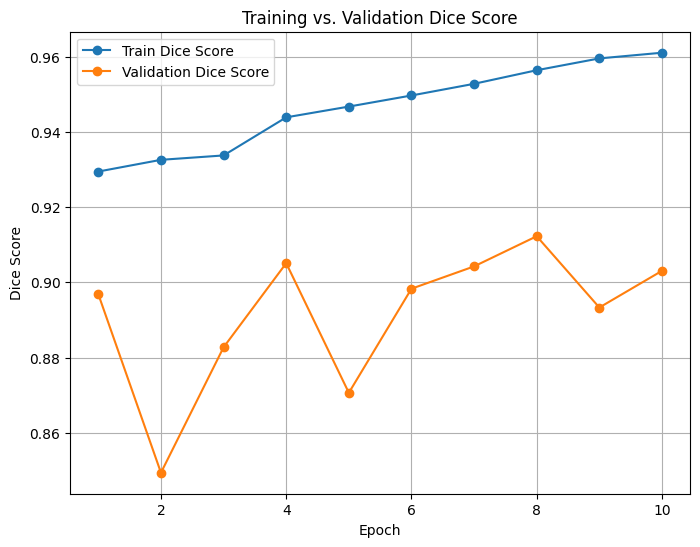

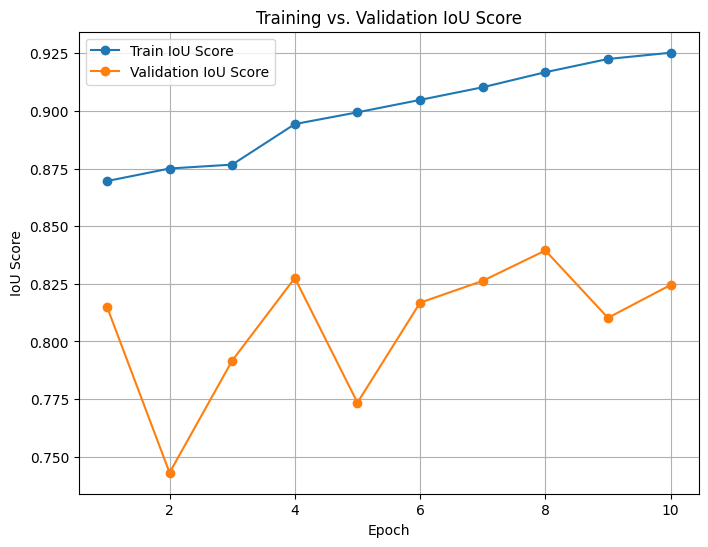

In [ ]:
import matplotlib.pyplot as plt

# Define the epoch numbers based on the number of epochs you trained for
epochs = range(1, num_epochs + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Dice Scores
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_dice_scores, marker='o', label='Train Dice Score')
plt.plot(epochs, val_dice_scores, marker='o', label='Validation Dice Score')
plt.title('Training vs. Validation Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation IoU Scores
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_iou_scores, marker='o', label='Train IoU Score')
plt.plot(epochs, val_iou_scores, marker='o', label='Validation IoU Score')
plt.title('Training vs. Validation IoU Score')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.legend()
plt.grid(True)
plt.show()

# Step 12: Pick a Random Test Image for Visualization

In [ ]:
# 1. Specify the paths to your test images and masks
test_images_path = f"{BASE_DIR}/test_images.npy"
test_masks_path  = f"{BASE_DIR}/test_masks.npy"

# 2. Instantiate the test dataset
test_dataset = ISICDataset(
    images_path=test_images_path,
    masks_path=test_masks_path,
    transform=None  # No augmentation for testing
)

# 3. Create the test DataLoader
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

# Quick check
print(f"Test dataset size: {len(test_dataset)} samples")

Test dataset size: 1000 samples


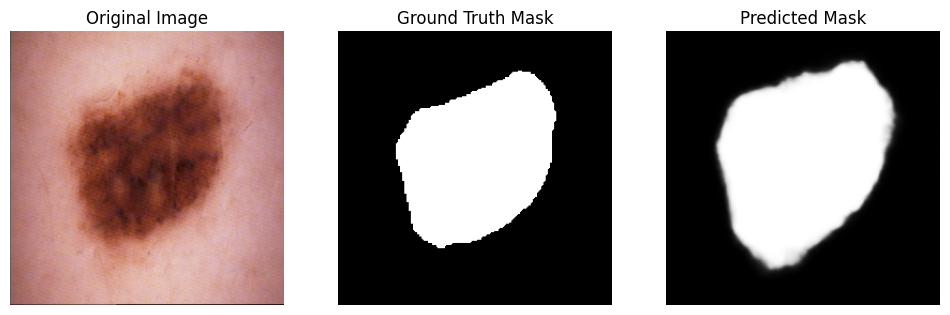

In [ ]:
# Get a random test sample
random_index = random.randint(0, len(test_dataset) - 1)
image, mask = test_dataset[random_index]  # Load image & mask from test dataset

# Convert to batch format (add batch dimension)
image_tensor = image.unsqueeze(0).to(device)

# Get model prediction
with torch.no_grad():
    pred_mask = best_model(image_tensor)  # Forward pass
    pred_mask = torch.sigmoid(pred_mask)  # Apply sigmoid activation
    pred_mask = pred_mask.squeeze().cpu().numpy()  # Remove batch & move to CPU

# Convert original image & mask to NumPy for visualization
image_np = image.permute(1, 2, 0).cpu().numpy()  # Change shape from (C, H, W) → (H, W, C)
mask_np = mask.cpu().numpy()  # Convert ground truth mask to NumPy

# Plot images side by side
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(image_np)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(mask_np, cmap="gray")
ax[1].set_title("Ground Truth Mask")
ax[1].axis("off")

ax[2].imshow(pred_mask, cmap="gray")
ax[2].set_title("Predicted Mask")
ax[2].axis("off")

plt.show()

# Step 13: Compute Evaluation Metrics

Now that we have visually inspected the model’s predictions, the next step is to quantitatively evaluate its performance. We’ll compute common segmentation metrics:
1.	Dice Coefficient (F1 Score for Segmentation) – Measures the overlap between the predicted and ground truth masks.
2.	Intersection over Union (IoU/Jaccard Index) – Measures how well the predicted mask matches the true mask.
3.	Pixel Accuracy – Measures the percentage of correctly predicted pixels.

In [ ]:
# Define metric functions (explicitly set `num_classes=2`)
dice_metric = torchmetrics.Dice(num_classes=2, threshold=0.5, average="micro").to(device)
iou_metric = torchmetrics.JaccardIndex(num_classes=2, task="binary").to(device)

# Convert NumPy arrays back to PyTorch tensors before thresholding
pred_mask_tensor = torch.tensor(pred_mask).to(device)
mask_tensor = torch.tensor(mask).to(device)

# Convert tensors to binary masks
pred_binary = (pred_mask_tensor > 0.5).int()  # Convert predictions to int
mask_binary = (mask_tensor > 0.5).int()  # Convert ground truth mask to int

# Compute Dice and IoU scores
dice_score = dice_metric(pred_binary, mask_binary)
iou_score = iou_metric(pred_binary, mask_binary)

print(f"Dice Score: {dice_score.item():.4f}")
print(f"IoU Score: {iou_score.item():.4f}")

Dice Score: 0.9275
IoU Score: 0.7868


<ipython-input-21-41a54100b11b>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_tensor = torch.tensor(mask).to(device)


# Step 14: Saving the Model In Goole Drive

In [ ]:
# Define model save path
MODEL_DIR = "/content/drive/MyDrive/swinunet-medical-segmentation/models"

# Ensure the directory exists
os.makedirs(MODEL_DIR, exist_ok=True)

# Copy best model to Google Drive (inside models folder)
!cp best_unet.pth {MODEL_DIR}/best_unet.pth
print(f"✅ Model saved to: {MODEL_DIR}/best_unet.pth")

✅ Model saved to: /content/drive/MyDrive/swinunet-medical-segmentation/models/best_unet.pth


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
